In [121]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.svm import SVC

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight


In [122]:
input_dir = '/kaggle/input/air-quality-index-of-bangladesh-dataset'
print(os.listdir(input_dir))


['air_quality_index_dataset.xlsx']


In [123]:
file_path = '/kaggle/input/air-quality-index-of-bangladesh-dataset/air_quality_index_dataset.xlsx'

In [124]:
sheets_dict = pd.read_excel(file_path, sheet_name=None)  # Read all sheets
df_list = []
for sheet_name, df in sheets_dict.items():
    df['Location'] = sheet_name  # Add sheet name as location
    df_list.append(df)

data = pd.concat(df_list, ignore_index=True)

In [125]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 944182 entries, 0 to 944181
Data columns (total 23 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Date          936063 non-null  object 
 1   Time          813064 non-null  object 
 2   SO2           471656 non-null  object 
 3   NO            487774 non-null  float64
 4   NO2           484768 non-null  float64
 5   NOX           533675 non-null  object 
 6   CO            515964 non-null  float64
 7   CO 8hr        461844 non-null  float64
 8   O3            531487 non-null  float64
 9   O3 8hr        469219 non-null  object 
 10  PM2.5         591370 non-null  object 
 11  PM10          572628 non-null  object 
 12  Wind Speed    427700 non-null  object 
 13  Wind Dir      438815 non-null  object 
 14  Temperature   465850 non-null  float64
 15  RH            475237 non-null  float64
 16  Solar Rad     426815 non-null  float64
 17  BP            424428 non-null  float64
 18  Rain

In [126]:
data.isnull().sum()

Date              8119
Time            131118
SO2             472526
NO              456408
NO2             459414
NOX             410507
CO              428218
CO 8hr          482338
O3              412695
O3 8hr          474963
PM2.5           352812
PM10            371554
Wind Speed      516482
Wind Dir        505367
Temperature     478332
RH              468945
Solar Rad       517367
BP              519754
Rain            646690
V Wind Speed    829316
Unnamed: 20     944179
Location             0
Unnamed: 21     944180
dtype: int64

In [127]:
data['Location'].value_counts()

Location
Rajshahi              88180
BARC                  80135
Gazipur               80064
Darussalam            80064
Agrabad Chittagong    80064
Barishal              80064
Khulna                80064
Sylhet                80064
TV st-Chittagong      80063
Narayonganj           80063
Sangsad               58392
Rangpur               17256
Cumilla               17255
Mymansingh            17255
Narsingdi             17255
Savar                  7944
Name: count, dtype: int64

In [128]:
print(data.columns)
print(data.isnull().sum())

Index(['Date', 'Time', 'SO2', 'NO', 'NO2', 'NOX', 'CO', 'CO 8hr', 'O3',
       'O3 8hr', 'PM2.5', 'PM10', 'Wind Speed', 'Wind Dir', 'Temperature',
       'RH', 'Solar Rad', 'BP', 'Rain', 'V Wind Speed', 'Unnamed: 20',
       'Location', 'Unnamed: 21'],
      dtype='object')
Date              8119
Time            131118
SO2             472526
NO              456408
NO2             459414
NOX             410507
CO              428218
CO 8hr          482338
O3              412695
O3 8hr          474963
PM2.5           352812
PM10            371554
Wind Speed      516482
Wind Dir        505367
Temperature     478332
RH              468945
Solar Rad       517367
BP              519754
Rain            646690
V Wind Speed    829316
Unnamed: 20     944179
Location             0
Unnamed: 21     944180
dtype: int64


In [129]:
data = data.drop(columns=[
    'Unnamed: 20', 'Unnamed: 21', 'Rain', 'V Wind Speed', 'CO 8hr',
    'O3 8hr', 'CO', 'NO', 'NO2', 'NOX', 'SO2', 'O3', 'PM10', 'Solar Rad', 'BP', 'Wind Dir'
])

In [130]:
# Step 1: Convert both Date and Time to string first
data['Date'] = data['Date'].astype(str)
data['Time'] = data['Time'].astype(str)

# Step 2: Combine into one Datetime column
data['Datetime'] = pd.to_datetime(data['Date'] + ' ' + data['Time'], errors='coerce')

data.drop(columns=['Date', 'Time'], inplace=True)

/tmp/ipykernel_31/2608046067.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['Datetime'] = pd.to_datetime(data['Date'] + ' ' + data['Time'], errors='coerce')


In [133]:
data = data.sort_values(['Location', 'Datetime'])

In [135]:
# Fix commas and convert to float for all relevant columns
for col in ['PM2.5', 'Temperature', 'RH', 'Wind Speed']:
    data[col] = data[col].astype(str).str.replace(',', '.', regex=False)  # replace comma with dot
    data[col] = pd.to_numeric(data[col], errors='coerce')  # convert to float, turn invalids into NaN

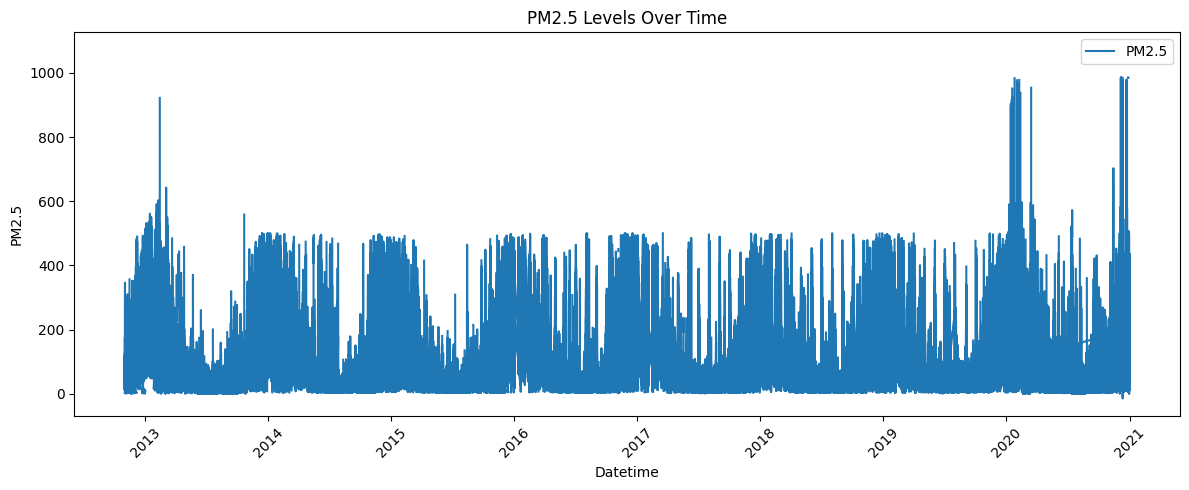

In [136]:
plt.figure(figsize=(12, 5))
plt.plot(data['Datetime'], data['PM2.5'], label='PM2.5')
plt.xlabel('Datetime')
plt.ylabel('PM2.5')
plt.title('PM2.5 Levels Over Time')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


In [145]:
data['PM2.5'] = data.groupby('Location')['PM2.5'].transform(lambda x: x.fillna(x.median()))
data['Temperature'] = data.groupby('Location')['Temperature'].transform(lambda x: x.fillna(x.median()))
data['RH'] = data.groupby('Location')['RH'].transform(lambda x: x.fillna(x.median()))
data['Wind Speed'] = data.groupby('Location')['Wind Speed'].transform(lambda x: x.fillna(x.median()))

In [146]:
data.head(10)

,PM2.5,Wind Speed,Temperature,RH,Location,Datetime
458781,54.59,1.72,26.83,82.98,Agrabad Chittagong,2012-11-01 01:00:00
458782,73.07,1.95,26.63,79.61,Agrabad Chittagong,2012-11-01 02:00:00
458783,42.11,2.02,25.76,83.86,Agrabad Chittagong,2012-11-01 03:00:00
458784,46.09,1.81,25.17,87.53,Agrabad Chittagong,2012-11-01 04:00:00
458785,48.84,1.87,24.85,75.63,Agrabad Chittagong,2012-11-01 05:00:00
458786,43.06,2.53,24.80,75.63,Agrabad Chittagong,2012-11-01 06:00:00
458787,45.20,2.42,25.90,86.20,Agrabad Chittagong,2012-11-01 07:00:00
458788,52.14,2.36,27.82,79.07,Agrabad Chittagong,2012-11-01 08:00:00
458789,56.96,3.01,29.17,72.59,Agrabad Chittagong,2012-11-01 09:00:00
458790,54.47,2.46,26.10,65.21,Agrabad Chittagong,2012-11-01 10:00:00


In [147]:
data.isnull().sum()

PM2.5               0
Wind Speed       7944
Temperature      7944
RH               7944
Location            0
Datetime       172697
dtype: int64

In [148]:
for col in ['Temperature', 'RH', 'Wind Speed']:
    data[col] = data[col].fillna(data[col].median())

In [149]:
def categorize_aqi(pm):
    if pm <= 50:
        return 'Good'
    elif pm <= 100:
        return 'Moderate'
    else:
        return 'Unhealthy'

data['AQI_Category'] = data['PM2.5'].apply(categorize_aqi)

In [150]:
data['Hour'] = data['Datetime'].dt.hour
data['Day'] = data['Datetime'].dt.day
data['Month'] = data['Datetime'].dt.month
data['Weekday'] = data['Datetime'].dt.weekday  # 0 = Monday

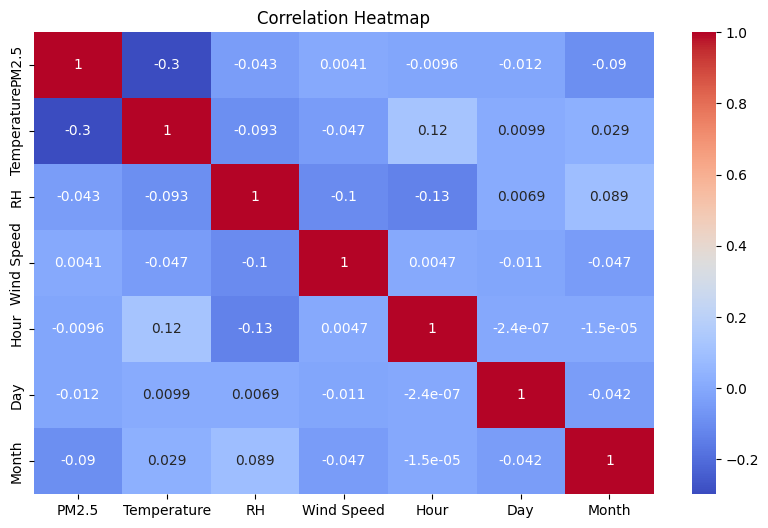

In [151]:
features = ['PM2.5', 'Temperature', 'RH', 'Wind Speed', 'Hour', 'Day', 'Month']
plt.figure(figsize=(10, 6))
sns.heatmap(data[features].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()


In [152]:
le = LabelEncoder()
data['AQI_Label'] = le.fit_transform(data['AQI_Category'])  # Good=0, Moderate=1, Unhealthy=2


In [153]:
data.head()

,PM2.5,Wind Speed,Temperature,RH,Location,Datetime,AQI_Category,Hour,Day,Month,Weekday,AQI_Label
458781,54.59,1.72,26.83,82.98,Agrabad Chittagong,2012-11-01 01:00:00,Moderate,1.0,1.0,11.0,3.0,1
458782,73.07,1.95,26.63,79.61,Agrabad Chittagong,2012-11-01 02:00:00,Moderate,2.0,1.0,11.0,3.0,1
458783,42.11,2.02,25.76,83.86,Agrabad Chittagong,2012-11-01 03:00:00,Good,3.0,1.0,11.0,3.0,0
458784,46.09,1.81,25.17,87.53,Agrabad Chittagong,2012-11-01 04:00:00,Good,4.0,1.0,11.0,3.0,0
458785,48.84,1.87,24.85,75.63,Agrabad Chittagong,2012-11-01 05:00:00,Good,5.0,1.0,11.0,3.0,0


In [154]:
data_clean = data.dropna(subset=['Datetime', 'Hour', 'Day', 'Month', 'PM2.5','Wind Speed', 'Temperature','RH','Location','AQI_Category','AQI_Label', 'Weekday'])


In [155]:
data_clean.isnull().sum()

PM2.5           0
Wind Speed      0
Temperature     0
RH              0
Location        0
Datetime        0
AQI_Category    0
Hour            0
Day             0
Month           0
Weekday         0
AQI_Label       0
dtype: int64

Class Distribution:
 AQI_Label
0    350697
1    287490
2    133298
Name: count, dtype: int64


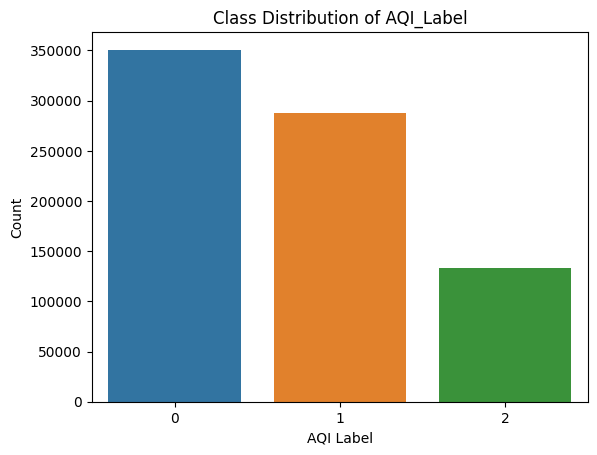

In [156]:
# Check class distribution
class_counts = data_clean['AQI_Label'].value_counts().sort_index()
print("Class Distribution:\n", class_counts)

# Optional: visualize
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.xlabel("AQI Label")
plt.ylabel("Count")
plt.title("Class Distribution of AQI_Label")
plt.show()


In [157]:
X = data_clean[['Temperature', 'RH', 'Wind Speed', 'Hour', 'Day', 'Month']]
y = data_clean['AQI_Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [158]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [159]:
model = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    min_samples_split=10,
    min_samples_leaf=4,
    random_state=42
)

model.fit(X_train_scaled, y_train)


RandomForestClassifier(max_depth=20, min_samples_leaf=4, min_samples_split=10,
                       random_state=42)

In [160]:
y_pred = model.predict(X_test_scaled)

print("Classification Report:")
print(classification_report(y_test, y_pred))

print(f"Training Accuracy: {model.score(X_train_scaled, y_train):.4f}")
print(f"Testing Accuracy: {accuracy_score(y_test, y_pred):.4f}")


Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.83      0.82     69987
           1       0.72      0.70      0.71     57664
           2       0.71      0.68      0.70     26646

    accuracy                           0.76    154297
   macro avg       0.74      0.74      0.74    154297
weighted avg       0.76      0.76      0.76    154297

Training Accuracy: 0.8215
Testing Accuracy: 0.7568


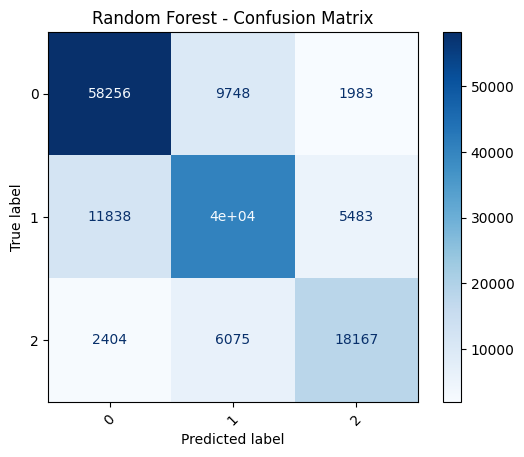

In [161]:
y_pred = model.predict(X_test_scaled)

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Random Forest - Confusion Matrix")
plt.show()

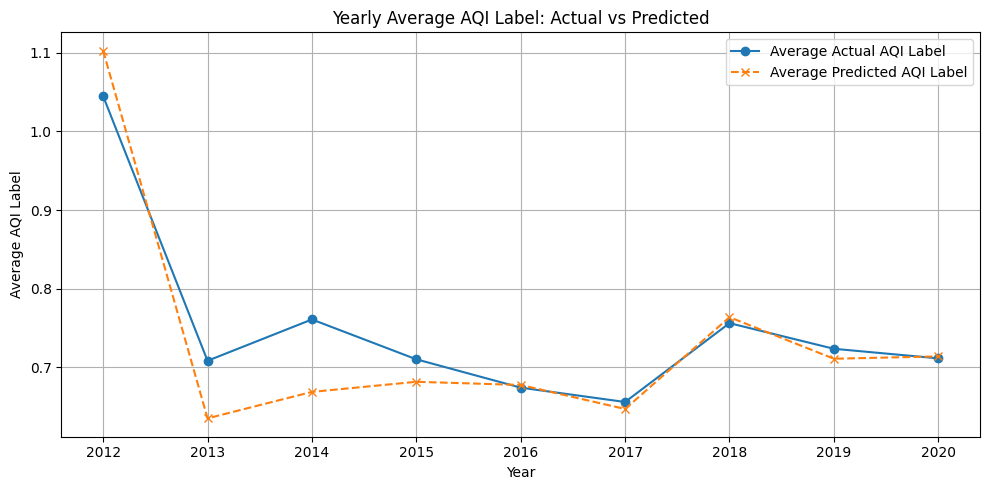

In [167]:
# Predict
y_pred = model.predict(X_test_scaled)

# Create a DataFrame only with test samples
X_test_with_time = data_clean.loc[X_test.index].copy()  # Only rows in the test set
X_test_with_time['y_test'] = y_test
X_test_with_time['y_pred'] = y_pred

# Convert 'Datetime' column to datetime if it's not already
X_test_with_time['Datetime'] = pd.to_datetime(X_test_with_time['Datetime'])

# Extract year
X_test_with_time['Year'] = X_test_with_time['Datetime'].dt.year

# Group by year and compute average labels
yearly_avg = X_test_with_time.groupby('Year')[['y_test', 'y_pred']].mean()

# Plot
plt.figure(figsize=(10, 5))
plt.plot(yearly_avg.index, yearly_avg['y_test'], label='Average Actual AQI Label', marker='o')
plt.plot(yearly_avg.index, yearly_avg['y_pred'], label='Average Predicted AQI Label', marker='x', linestyle='--')

plt.title('Yearly Average AQI Label: Actual vs Predicted')
plt.xlabel('Year')
plt.ylabel('Average AQI Label')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [171]:
models = {
    "Decision Tree": DecisionTreeClassifier(
    max_depth=30,
    min_samples_split=10,
    min_samples_leaf=5,
    criterion='entropy',
    random_state=42),
    
    "KNN": KNeighborsClassifier(n_neighbors=5, weights='distance', metric='manhattan'),
    
    "AdaBoost": AdaBoostClassifier(
    n_estimators=300,
    learning_rate=0.5,
    random_state=42),
    
    "XGBoost": XGBClassifier(
    n_estimators=300,
    max_depth=8,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='mlogloss',
    random_state=42,
    use_label_encoder=False),

    "LGBMC": LGBMClassifier(n_estimators=300, learning_rate=0.05, max_depth=8, random_state=42),

     "CatBoost": CatBoostClassifier(
        iterations=300,
        learning_rate=0.05,
        depth=8,
        verbose=0,
        random_state=42)
   

}

# Train and evaluate
for name, clf in models.items():
    print(f"\n{'='*10} {name} {'='*10}")
    clf.fit(X_train_scaled, y_train)
    y_pred = clf.predict(X_test_scaled)
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))



========== Decision Tree ==========
Accuracy: 0.7128784098200224
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.79      0.78     69987
           1       0.66      0.67      0.67     57664
           2       0.67      0.59      0.63     26646

    accuracy                           0.71    154297
   macro avg       0.70      0.69      0.69    154297
weighted avg       0.71      0.71      0.71    154297


========== KNN ==========
Accuracy: 0.7101239816717111
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.80      0.78     69987
           1       0.67      0.65      0.66     57664
           2       0.66      0.62      0.64     26646

    accuracy                           0.71    154297
   macro avg       0.70      0.69      0.69    154297
weighted avg       0.71      0.71      0.71    154297


========== AdaBoost ==========
Accuracy: 0.6618404764836646
Classif

In [172]:
for name, model in models.items():
    y_pred = model.predict(X_test_scaled)  # Predict for this specific model
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)

    print(f"\n{name}:")
    print(f"  MAE: {mae:.4f}")
    print(f"  MSE: {mse:.4f}")


Decision Tree:
  MAE: 0.3232
  MSE: 0.3953

KNN:
  MAE: 0.3266
  MSE: 0.4002

AdaBoost:
  MAE: 0.3844
  MSE: 0.4770

XGBoost:
  MAE: 0.2891
  MSE: 0.3497

LGBMC:
  MAE: 0.3180
  MSE: 0.3875

CatBoost:
  MAE: 0.3294
  MSE: 0.4001


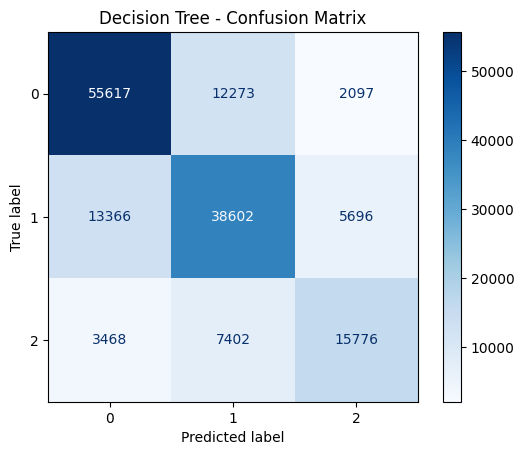

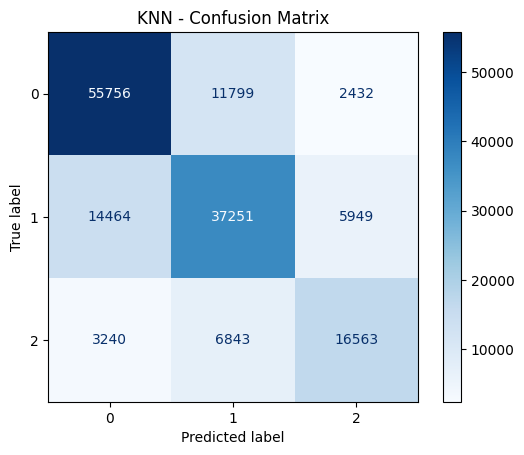

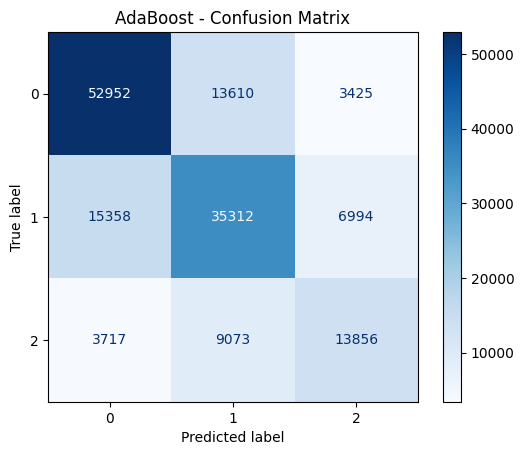

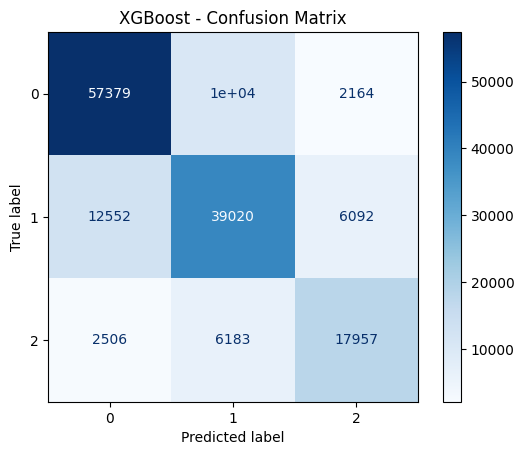

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005038 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 834
[LightGBM] [Info] Number of data points in the train set: 617188, number of used features: 6
[LightGBM] [Info] Start training from score -0.787852
[LightGBM] [Info] Start training from score -0.987851
[LightGBM] [Info] Start training from score -1.755602


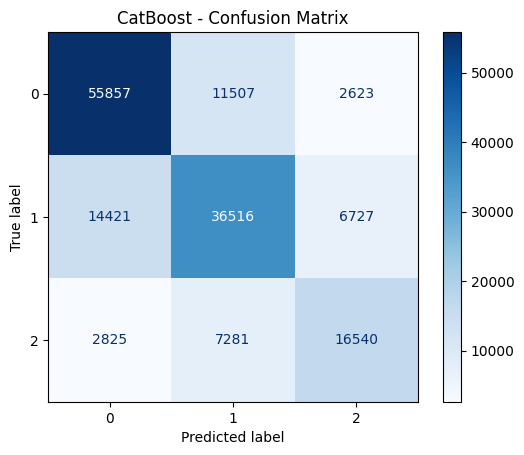

In [173]:
for name, clf in models.items():
    clf.fit(X_train_scaled, y_train)
    y_pred = clf.predict(X_test_scaled)
    cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
    disp.plot(cmap="Blues")
    plt.title(f"{name} - Confusion Matrix")
    plt.show()


In [174]:
# Features and labels
X = data_clean[['Temperature', 'RH', 'Wind Speed', 'Hour', 'Day', 'Month']]
y = data_clean['AQI_Label']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert labels to one-hot encoding
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)


In [175]:
model = Sequential()
model.add(Dense(256, input_dim=X_train_scaled.shape[1], activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(Dense(64, activation='relu'))
model.add(Dense(3, activation='softmax'))   # 3 classes: Good, Moderate, Unhealthy
# Compile
optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
]
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weight_dict = dict(enumerate(class_weights))

# Train
history = model.fit(X_train_scaled, y_train_cat, epochs=100, batch_size=128, validation_split=0.2,callbacks=callbacks)


Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3858/3858 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.5837 - loss: 0.8481 - val_accuracy: 0.6648 - val_loss: 0.7299 - learning_rate: 5.0000e-04
Epoch 2/100
3858/3858 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.6596 - loss: 0.7364 - val_accuracy: 0.6792 - val_loss: 0.7094 - learning_rate: 5.0000e-04
Epoch 3/100
3858/3858 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.6734 - loss: 0.7125 - val_accuracy: 0.6887 - val_loss: 0.6872 - learning_rate: 5.0000e-04
Epoch 4/100
3858/3858 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.6803 - loss: 0.7006 - val_accuracy: 0.6904 - val_loss: 0.6839 - learning_rate: 5.0000e-04
Epoch 5/100
3858/3858 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.6832 - loss: 0.6950 - val_accuracy: 0.6929 - val_loss: 0.6770 - learning_rate: 5.0000e-04
Epoch 6/100
3858/3858 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.6852 - loss: 0.6899 - val_accuracy: 0.6958 - val_loss: 0.6718 - learning_rate: 5.0000e-04
Epoch 7/100
3858/3858 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - 

In [177]:
# Evaluate
loss, accuracy = model.evaluate(X_test_scaled, y_test_cat)
print(f"\nTest Accuracy: {accuracy:.4f}")


4822/4822 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.7177 - loss: 0.6324

Test Accuracy: 0.7169


In [178]:
y_pred_probs = model.predict(X_test_scaled)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

print(classification_report(y_test, y_pred_classes))


4822/4822 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step
              precision    recall  f1-score   support

           0       0.77      0.81      0.79     69987
           1       0.68      0.63      0.66     57664
           2       0.64      0.66      0.65     26646

    accuracy                           0.72    154297
   macro avg       0.70      0.70      0.70    154297
weighted avg       0.72      0.72      0.72    154297



In [183]:
if isinstance(y_test, pd.Series):
    y_true = y_test.values
else:
    y_true = y_test

# Calculate MAE and MSE
mae = mean_absolute_error(y_true, y_pred_classes)
mse = mean_squared_error(y_true, y_pred_classes)

print(f"MAE (Neural Network): {mae:.4f}")
print(f"MSE (Neural Network): {mse:.4f}")

MAE (Neural Network): 0.3182
MSE (Neural Network): 0.3884


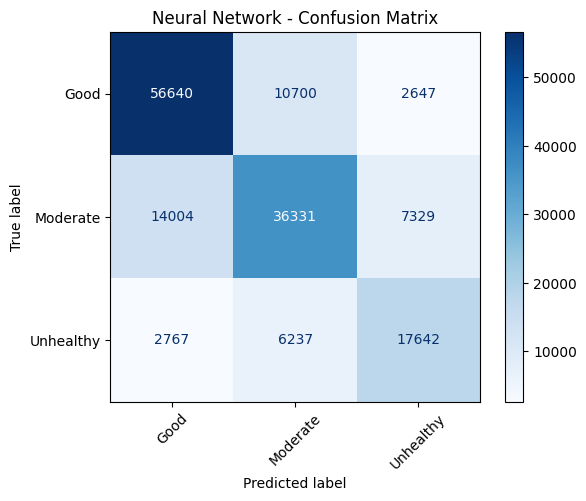

In [182]:
# Convert softmax outputs to class predictions
y_pred_classes = np.argmax(y_pred, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Good', 'Moderate', 'Unhealthy'])
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Neural Network - Confusion Matrix")
plt.show()


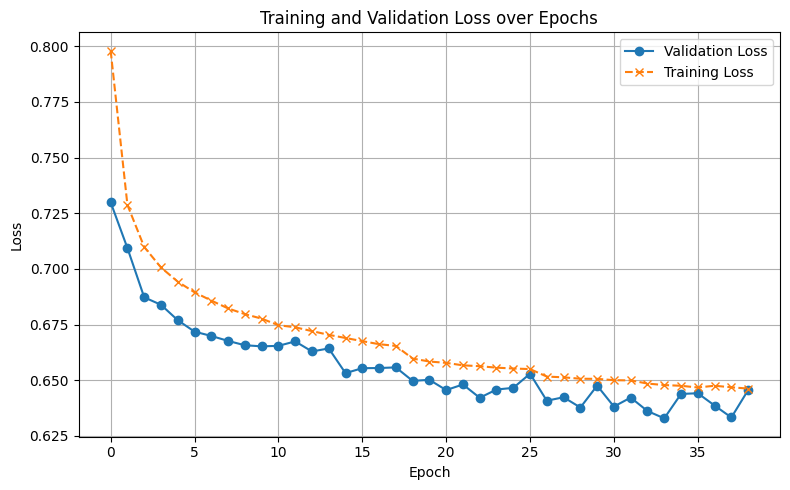

In [185]:
# Plot validation loss
plt.figure(figsize=(8, 5))
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.plot(history.history['loss'], label='Training Loss', marker='x', linestyle='--')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# from sklearn.model_selection import RandomizedSearchCV
# from xgboost import XGBClassifier

# param_dist = {
#     'n_estimators': [100, 200, 300],
#     'learning_rate': [0.01, 0.05, 0.1, 0.2],
#     'max_depth': [4, 6, 8, 10],
#     'subsample': [0.6, 0.8, 1.0],
#     'colsample_bytree': [0.6, 0.8, 1.0],
#     'gamma': [0, 0.1, 0.3],
# }

# xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)

# random_search = RandomizedSearchCV(
#     estimator=xgb,
#     param_distributions=param_dist,
#     n_iter=20,
#     scoring='accuracy',
#     cv=3,
#     verbose=2,
#     random_state=42,
#     n_jobs=1  
# )

# random_search.fit(X_train_scaled, y_train)
# best_model = random_search.best_estimator_

# # Evaluate
# y_pred = best_model.predict(X_test_scaled)
# print("Accuracy:", accuracy_score(y_test, y_pred))
# print("Report:\n", classification_report(y_test, y_pred))


In [ ]:
# from sklearn.ensemble import VotingClassifier

# ensemble = VotingClassifier(
#     estimators=[
#         ('xgb', best_model),
#         ('rf', RandomForestClassifier(random_state=42)),
#         ('knn', KNeighborsClassifier(n_neighbors=5, weights='distance'))
#     ],
#     voting='soft'  # soft uses predicted probabilities, often better
# )
# ensemble.fit(X_train_scaled, y_train)
# y_pred = ensemble.predict(X_test_scaled)
# print("Ensemble Accuracy:", accuracy_score(y_test, y_pred))


In [ ]:
# svm_model = SVC(kernel='rbf', random_state=42)
# svm_model.fit(X_train_scaled, y_train)
# svm_pred = svm_model.predict(X_test_scaled)

# print("SVM Accuracy:", accuracy_score(y_test, svm_pred))
# print("SVM Classification Report:\n", classification_report(y_test, svm_pred))

In [ ]:
# from sklearn.svm import SVC
# from sklearn.metrics import accuracy_score, classification_report

# # Sample a subset from training data
# X_sampled = X_train_scaled[:50000]
# y_sampled = y_train[:50000]

# # Train SVM with RBF kernel
# svm_rbf = SVC(kernel='rbf', random_state=42)
# svm_rbf.fit(X_sampled, y_sampled)

# # Predict on full test set
# y_pred = svm_rbf.predict(X_test_scaled)

# # Evaluate
# print("Accuracy:", accuracy_score(y_test, y_pred))
# print("Classification Report:\n", classification_report(y_test, y_pred))
